In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import module

np.random.seed(42)

# Load Svensson parameter file
df_sv = pd.read_excel("svensson_parameters_cleaned.xlsx", parse_dates=['Date'])

# Convert beta values from percent to decimal
df_sv[["beta0", "beta1", "beta2", "beta3"]] /= 100


def forward_rate(m, params):
    β0, β1, β2, β3, τ1, τ2 = params
    return (
        β0
        + β1 * np.exp(-m / τ1)
        + β2 * (m / τ1) * np.exp(-m / τ1)
        + β3 * (m / τ2) * np.exp(-m / τ2)
    )

def spot_rate(m, params):
    t = np.linspace(0.0001, m, 100)
    return np.trapz(forward_rate(t, params), t) / m

def get_daily_spot_rate(date, maturity=6.0):
    row = df_sv[df_sv["Date"] == date]
    if row.empty:
        return np.nan
    params = row[["beta0", "beta1", "beta2", "beta3", "tau1", "tau2"]].values[0]
    return spot_rate(maturity, params)


[*********************100%***********************]  1 of 1 completed


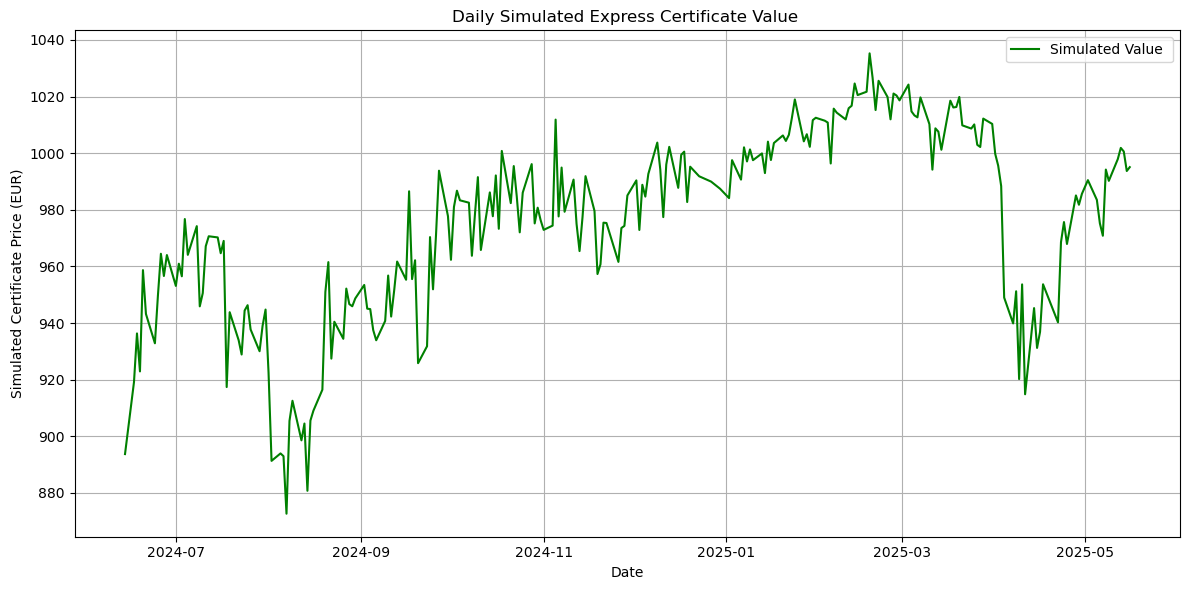

In [2]:

df_prices, _ = module.download_stock_price_data(['SIE.DE'], '2024-05-17', '2025-05-17')

# Prepare stock dataframe
df_stock = df_prices.rename(columns={"SIE.DE": "Close"}).reset_index()
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock = df_stock.sort_values("Date").reset_index(drop=True)
# Add risk-free rate to each day
df_stock["RiskFreeRate"] = df_stock["Date"].apply(get_daily_spot_rate)
# --- Parameters ---
S0=187.98
# Compute daily log returns
df_stock["LogReturn"] = np.log(df_stock["Close"] / df_stock["Close"].shift(1))

# Compute daily volatility as rolling std of log returns
df_stock["DailyVolatility"] = df_stock["LogReturn"].rolling(window=252, min_periods=20).std() * np.sqrt(252)
T_total = 6
N_total = 252 * T_total
dt = T_total / N_total
n_paths = 1000

nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0  # fixed based on S0

# --- Simulate each day using actual S_t ---
simulated_prices = []

for idx, row in df_stock.iterrows():
    S_t = float(row["Close"])  # actual stock price on that day
    r = df_stock.loc[idx, "RiskFreeRate"]
    sigma = df_stock.loc[idx, "DailyVolatility"]
    if pd.isna(sigma):
        continue  # skip this day if not enough data yet
    remaining_days = N_total - idx
    remaining_T = remaining_days / 252

    # Simulate paths
    Z = np.random.standard_normal((n_paths, remaining_days))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t

    for t in range(1, remaining_days):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Compute payoffs
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            if S_end >= barrier:
                val = nominal + total_coupon
            else:
                val = nominal * (S_end / S0)
            payoffs.append(np.exp(-r * remaining_T) * val)

    simulated_prices.append(np.mean(payoffs))

# --- Plot ---
plt.figure(figsize=(12, 6))
valid_dates = df_stock.loc[~df_stock["DailyVolatility"].isna(), "Date"].reset_index(drop=True)
plt.plot(valid_dates, simulated_prices, label="Simulated Value ", color="green")
plt.title("Daily Simulated Express Certificate Value ")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


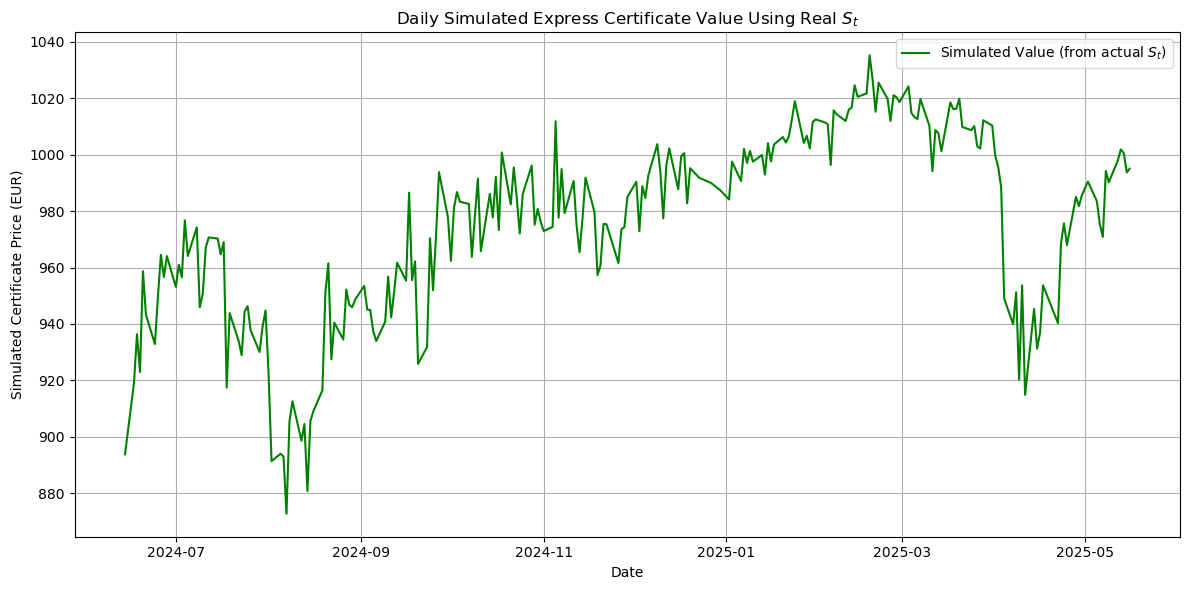

In [3]:

df_prices, _ = module.download_stock_price_data(['SIE.DE'], '2024-05-17', '2025-05-17')

# Prepare stock dataframe
df_stock = df_prices.rename(columns={"SIE.DE": "Close"}).reset_index()
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock = df_stock.sort_values("Date").reset_index(drop=True)
# Add risk-free rate to each day
df_stock["RiskFreeRate"] = df_stock["Date"].apply(get_daily_spot_rate)
# --- Parameters ---
S0=187.98


# Compute daily log returns
df_stock["LogReturn"] = np.log(df_stock["Close"] / df_stock["Close"].shift(1))

# Compute daily volatility as rolling std of log returns (252 trading days ≈ 1 year)
df_stock["DailyVolatility"] = df_stock["LogReturn"].rolling(window=504, min_periods=20).std() * np.sqrt(252)

T_total = 6
N_total = 252 * T_total
dt = T_total / N_total
n_paths = 1000

nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0  # fixed based on S0

# --- Simulate each day using actual S_t ---
simulated_prices_2y = []

for idx, row in df_stock.iterrows():
    S_t = float(row["Close"])  # actual stock price on that day
    r = df_stock.loc[idx, "RiskFreeRate"]
    sigma = df_stock.loc[idx, "DailyVolatility"]
    if pd.isna(sigma):
        continue  # skip this day if not enough data yet
    remaining_days = N_total - idx
    remaining_T = remaining_days / 252

    # Simulate paths
    Z = np.random.standard_normal((n_paths, remaining_days))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t

    for t in range(1, remaining_days):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Compute payoffs
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            if S_end >= barrier:
                val = nominal + total_coupon
            else:
                val = nominal * (S_end / S0)
            payoffs.append(np.exp(-r * remaining_T) * val)

    simulated_prices_2y.append(np.mean(payoffs))

# --- Plot ---
plt.figure(figsize=(12, 6))
valid_dates = df_stock.loc[~df_stock["DailyVolatility"].isna(), "Date"].reset_index(drop=True)
plt.plot(valid_dates, simulated_prices, label="Simulated Value (from actual $S_t$)", color="green")
plt.title("Daily Simulated Express Certificate Value Using Real $S_t$")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

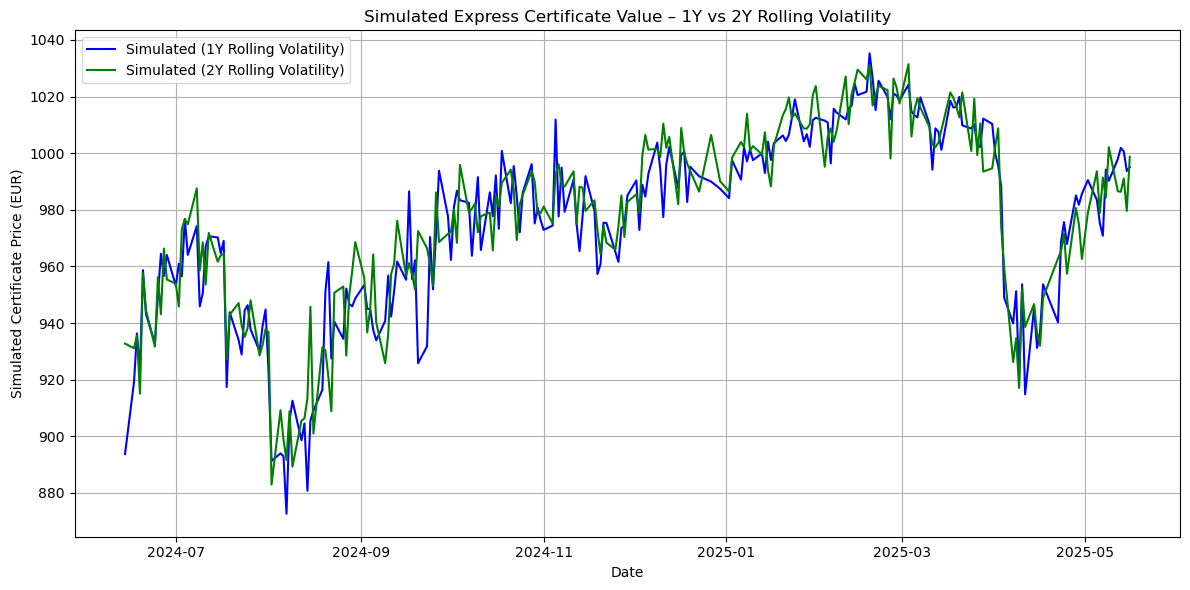

In [4]:
# reconstruct valid date ranges
valid_dates_1y = df_stock["Date"].iloc[-len(simulated_prices):].reset_index(drop=True)
valid_dates_2y = df_stock["Date"].iloc[-len(simulated_prices_2y):].reset_index(drop=True)

# Plot both simulations
plt.figure(figsize=(12, 6))
plt.plot(valid_dates_1y, simulated_prices, label="Simulated (1Y Rolling Volatility)", color="blue")
plt.plot(valid_dates_2y, simulated_prices_2y, label="Simulated (2Y Rolling Volatility)", color="green")

plt.title("Simulated Express Certificate Value – 1Y vs 2Y Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

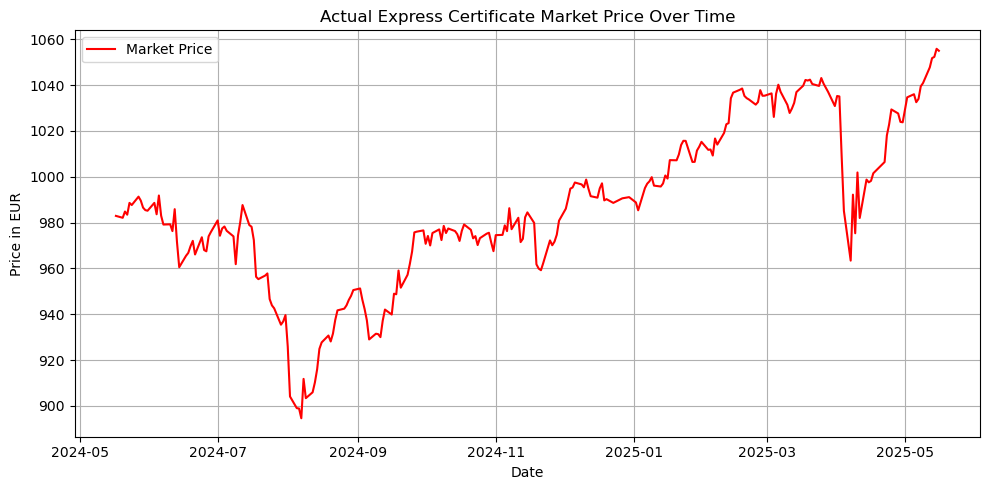

In [5]:


import pandas as pd
import matplotlib.pyplot as plt

# Load CSV with semicolon separator
df = pd.read_csv("certificate_price_data.csv", sep=";")

# Clean numeric columns: remove thousands separator and fix decimal
df["Schluss"] = df["Schluss"].str.replace(".", "", regex=False)  # remove thousand dots
df["Schluss"] = df["Schluss"].str.replace(",", ".", regex=False)  # change decimal comma to dot
df["Schluss"] = df["Schluss"].astype(float)

# Parse and sort dates
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df.sort_values("Datum")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df["Datum"], df["Schluss"], label="Market Price", color="red")
plt.title("Actual Express Certificate Market Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price in EUR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

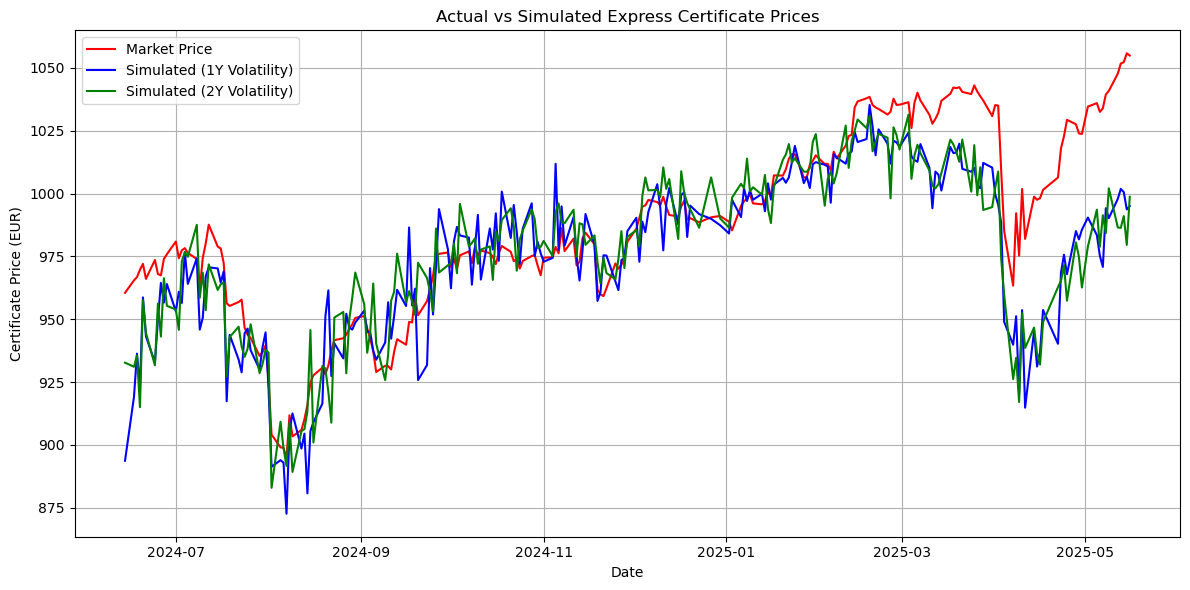

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and clean market data ---
df_market = pd.read_csv("certificate_price_data.csv", sep=";")
df_market["Schluss"] = df_market["Schluss"].str.replace(".", "", regex=False)
df_market["Schluss"] = df_market["Schluss"].str.replace(",", ".", regex=False)
df_market["Schluss"] = df_market["Schluss"].astype(float)
df_market["Datum"] = pd.to_datetime(df_market["Datum"], format="%d.%m.%Y")
df_market = df_market.sort_values("Datum").reset_index(drop=True)

# --- Reconstruct valid dates for both simulations ---
# 1Y simulation 
valid_dates_1y = df_stock["Date"].iloc[-len(simulated_prices):].reset_index(drop=True)

# 2Y simulation 
valid_dates_2y = df_stock["Date"].iloc[-len(simulated_prices_2y):].reset_index(drop=True)

# --- Align market data to the shortest of the two ---
min_length = min(len(valid_dates_1y), len(valid_dates_2y), len(df_market))
market_dates = df_market["Datum"].iloc[-min_length:].reset_index(drop=True)
market_prices = df_market["Schluss"].iloc[-min_length:].reset_index(drop=True)

# --- Align simulations accordingly ---
sim_1y_aligned = simulated_prices[-min_length:]
sim_2y_aligned = simulated_prices_2y[-min_length:]
dates_aligned = valid_dates_2y[-min_length:]  # Use 2y dates for x-axis

# --- Plot all together ---
plt.figure(figsize=(12, 6))
plt.plot(dates_aligned, market_prices, label="Market Price", color="red")
plt.plot(dates_aligned, sim_1y_aligned, label="Simulated (1Y Volatility)", color="blue")
plt.plot(dates_aligned, sim_2y_aligned, label="Simulated (2Y Volatility)", color="green")

plt.title("Actual vs Simulated Express Certificate Prices")
plt.xlabel("Date")
plt.ylabel("Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Align market prices to simulation dates
df_eval = df_market[df_market["Datum"].isin(valid_dates)].copy()
df_eval = df_eval.sort_values("Datum").reset_index(drop=True)
sim = pd.Series(simulated_prices, name="Simulated")
actual = df_eval["Schluss"].reset_index(drop=True)

# Step 2: Calculate errors
error = sim - actual
abs_error = error.abs()

# Metrics
mean_err = error.mean()
mae = mean_absolute_error(actual, sim)
rmse = mean_squared_error(actual, sim, squared=False)
quantiles = abs_error.quantile([0.25, 0.5, 0.75, 0.9])

# Display
print(f"Mean Error (Bias): {mean_err:.2f} EUR")
print(f"Mean Absolute Error (MAE): {mae:.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} EUR")
print("Absolute Error Quantiles:")
print(quantiles)

Mean Error (Bias): -11.50 EUR
Mean Absolute Error (MAE): 16.94 EUR
Root Mean Squared Error (RMSE): 23.91 EUR
Absolute Error Quantiles:
0.25     4.192869
0.50    10.733928
0.75    22.924584
0.90    44.996841
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Align market prices to simulation dates
df_eval = df_market[df_market["Datum"].isin(valid_dates)].copy()
df_eval = df_eval.sort_values("Datum").reset_index(drop=True)
sim = pd.Series(simulated_prices_2y, name="Simulated")
actual = df_eval["Schluss"].reset_index(drop=True)

# Step 2: Calculate errors
error = sim - actual
abs_error = error.abs()

# Metrics
mean_err = error.mean()
mae = mean_absolute_error(actual, sim)
rmse = mean_squared_error(actual, sim, squared=False)
quantiles = abs_error.quantile([0.25, 0.5, 0.75, 0.9])

# Display
print(f"Mean Error (Bias): {mean_err:.2f} EUR")
print(f"Mean Absolute Error (MAE): {mae:.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} EUR")
print("Absolute Error Quantiles:")
print(quantiles)

Mean Error (Bias): -9.82 EUR
Mean Absolute Error (MAE): 17.31 EUR
Root Mean Squared Error (RMSE): 24.06 EUR
Absolute Error Quantiles:
0.25     5.083768
0.50    11.383271
0.75    23.835750
0.90    43.510778
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
